Задача: Классификация результатов матчей Премьер-лиги на основе характеристик матча. Цель — предсказать исход для домашней команды, основываясь на статистике игры: количество голов, владение мячом, ожидаемые голы и другие данные.

In [1]:
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [18]:
path = kagglehub.dataset_download("mhmdkardosha/premier-league-matches")
print("Path to dataset files:", path)
file_path = 'C:\\Users\\vesel\\.cache\\kagglehub\\datasets\\mhmdkardosha\\premier-league-matches\\versions\\1\\matches.csv'
data = pd.read_csv(file_path)
print(data.shape)
print(data.head())

Path to dataset files: C:\Users\vesel\.cache\kagglehub\datasets\mhmdkardosha\premier-league-matches\versions\1
(4788, 28)
   Unnamed: 0        date           time            comp        round  day  \
0           0  2020-09-21  20:15 (21:15)  Premier League  Matchweek 2  Mon   
1           2  2020-09-27  16:30 (17:30)  Premier League  Matchweek 3  Sun   
2           4  2020-10-03  17:30 (18:30)  Premier League  Matchweek 4  Sat   
3           5  2020-10-17  17:30 (18:30)  Premier League  Matchweek 5  Sat   
4           7  2020-10-24  12:30 (13:30)  Premier League  Matchweek 6  Sat   

  venue result  gf  ga  ...  match report  notes  sh  sot  dist fk pk pkatt  \
0  Away      W   3   1  ...  Match Report    NaN  13    8  21.1  2  1     1   
1  Home      L   2   5  ...  Match Report    NaN  16    5  19.8  1  0     0   
2  Away      D   1   1  ...  Match Report    NaN  23    1  18.2  1  0     0   
3  Home      W   1   0  ...  Match Report    NaN  13    5  17.7  0  0     0   
4  Away      D

Определим основные статистические показатели и создадим корреляционную матрицу для анализа взаимосвязи между числовыми признаками.

In [19]:
# Описательная статистика
print(data.describe())

        Unnamed: 0           gf           ga           xg          xga  \
count  4788.000000  4788.000000  4788.000000  4788.000000  4788.000000   
mean     63.044069     1.447995     1.405388     1.396512     1.364745   
std      42.865191     1.312635     1.286927     0.828847     0.814947   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%      28.000000     0.000000     0.000000     0.800000     0.700000   
50%      62.000000     1.000000     1.000000     1.300000     1.200000   
75%      87.000000     2.000000     2.000000     1.900000     1.800000   
max     182.000000     9.000000     9.000000     7.000000     7.000000   

              poss    attendance  notes           sh          sot  \
count  4788.000000   3155.000000    0.0  4788.000000  4788.000000   
mean     50.432957  38397.586688    NaN    12.619256     4.261278   
std      12.810958  17595.849137    NaN     5.548444     2.459963   
min      18.000000   2000.000000    NaN     0.000000     

gf (забитые голы): Среднее значение близко к нулю, а стандартное отклонение составляет 1, что указывает на нормальное распределение значений вокруг среднего. Однако минимальное значение — -1.10, что нелогично для забитых голов (нельзя забить отрицательное количество голов). Максимальное значение — 5.75, что предполагает, что некоторые команды в среднем забивают до 5.75 голов, но отрицательные значения требуют проверки данных на ошибки.

ga (пропущенные голы): Показатели схожи со столбцом gf — среднее значение также около нуля, а стандартное отклонение равно 1. Это указывает на стандартизацию данных. Однако, как и в случае с gf, отрицательные значения в контексте пропущенных голов не имеют смысла и могут требовать корректировки.

opponent (соперник): Этот столбец, вероятно, содержит код или идентификатор команды-соперника. Среднее значение 12 предполагает, что данные охватывают команды разного уровня (идентификаторы варьируются от 0 до 25). Умеренное стандартное отклонение указывает на то, что команды встречаются с соперниками, которые распределены по этому диапазону.

attendance (посещаемость): Средняя посещаемость составляет примерно 38,398 зрителей, однако разброс значительный — от 2,000 до 75,000. Это может говорить о том, что популярность матчей варьируется в зависимости от значимости игры и уровня популярности команд, участвующих в матче.

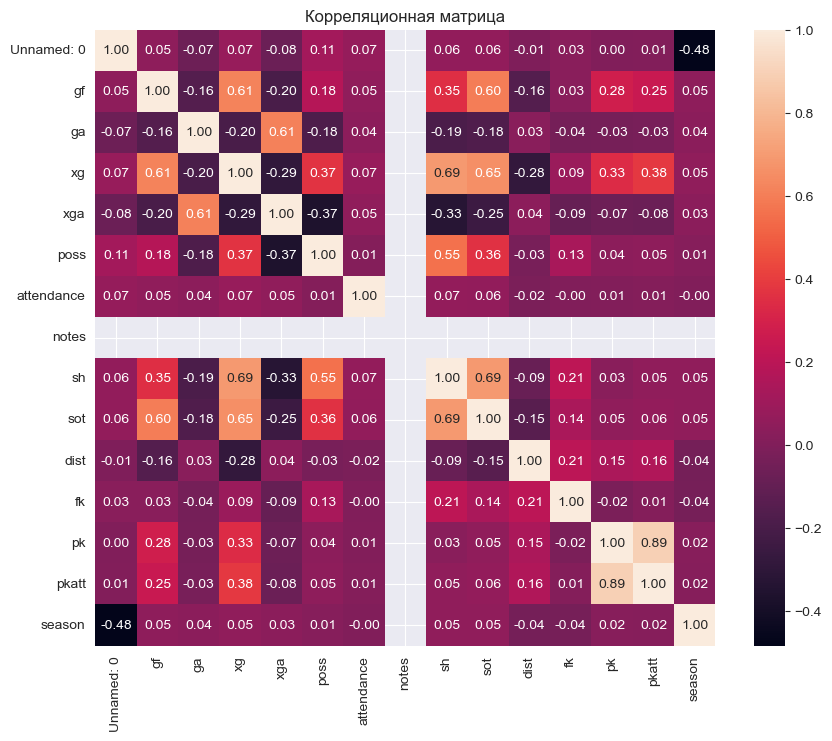

In [20]:
# Корреляционная матрица
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(numeric_only=True), annot=True, fmt=".2f")
plt.title('Корреляционная матрица')
plt.show()

Корреляционная матрица отображает взаимосвязь между различными числовыми показателями. Значения корреляции находятся в диапазоне от -1 до 1:

- Значение 1 указывает на идеальную положительную связь между показателями (когда один увеличивается, другой тоже увеличивается).
- Значение -1 указывает на идеальную отрицательную связь (когда один показатель увеличивается, другой уменьшается).
- Значение 0 говорит об отсутствии связи между показателями (изменения одного не влияют на другой).

In [11]:
# Проверка пропусков
print(data.isnull().sum())

# Заполнение пропусков
data['attendance'].fillna(data['attendance'].mean(), inplace=True)
data['dist'].fillna(data['dist'].mean(), inplace=True)
data.drop(columns=['notes'], inplace=True)

# Проверка отсутствия пропусков
print(data.isnull().sum())

Unnamed: 0         0
date               0
time               0
comp               0
round              0
day                0
venue              0
result             0
gf                 0
ga                 0
opponent           0
xg                 0
xga                0
poss               0
attendance      1633
captain            0
formation          0
referee            0
match report       0
notes           4788
sh                 0
sot                0
dist               2
fk                 0
pk                 0
pkatt              0
season             0
team               0
dtype: int64
Unnamed: 0      0
date            0
time            0
comp            0
round           0
day             0
venue           0
result          0
gf              0
ga              0
opponent        0
xg              0
xga             0
poss            0
attendance      0
captain         0
formation       0
referee         0
match report    0
sh              0
sot             0
dist            0
fk 

C:\Users\vesel\AppData\Local\Temp\ipykernel_4764\3455461390.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['attendance'].fillna(data['attendance'].mean(), inplace=True)
C:\Users\vesel\AppData\Local\Temp\ipykernel_4764\3455461390.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 

Используем LabelEncoder для преобразования категориальных признаков.

In [12]:
# Преобразование категориальных признаков
label_encoder = LabelEncoder()
categorical_features = ['team', 'opponent', 'result']  # укажите категории, которые нужно закодировать

for feature in categorical_features:
    data[feature] = label_encoder.fit_transform(data[feature])

Стандартизация числовых признаков, чтобы уменьшить влияние разницы в масштабах значений.

In [13]:
scaler = StandardScaler()
numeric_features = ['gf', 'ga', 'xg', 'xga', 'poss']
data[numeric_features] = scaler.fit_transform(data[numeric_features])

Разделим данные на обучающую и тестовую выборки, чтобы оценить модель.

In [14]:
# Определение признаков (X) и целевого признака (y)
X = data[['gf', 'ga', 'xg', 'xga', 'poss']]  # Признаки
y = data['result']  # Целевая переменная

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Выбираем классификатор KNN, так как он подходит для небольшой выборки и легко интерпретируем.

In [15]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

Выберем оптимальное значение гиперпараметра n_neighbors и оценим точность модели.

In [16]:
# Предсказания и оценка точности
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)

print(f'Точность на обучающей выборке: {accuracy_score(y_train, y_train_pred)}')
print(f'Точность на тестовой выборке: {accuracy_score(y_test, y_test_pred)}')

Точность на обучающей выборке: 0.9934725848563969
Точность на тестовой выборке: 0.988517745302714


1. Голы и ожидаемые голы (xG, xGA)

Параметры gf (голевые удары) и xg (ожидаемые голы) имеют высокую положительную корреляцию (около 0.69). Это говорит о том, что команды, которые создают больше ожидаемых голов, также часто забивают больше голов. Это логично, так как ожидаемые голы должны отражать атакующую силу команды.
Также наблюдается сильная корреляция между ga (пропущенные голы) и xga (ожидаемые пропущенные голы). Это подтверждает, что ожидаемые пропущенные голы достаточно точно предсказывают реальное количество пропущенных мячей.

2. Владение мячом и эффективность

poss (владение мячом) имеет слабую корреляцию с gf и xg, что свидетельствует о том, что владение мячом само по себе не гарантирует забитых голов или высокого показателя ожидаемых голов. Это значит, что для достижения результата важны не только контроль мяча, но и качество атак.
Отсутствие сильной связи между poss и sh (удары по воротам) также указывает на то, что владение не обязательно ведет к большему количеству ударов.

3. Аудитория на матчах

attendance (посещаемость) имеет незначительные корреляции со всеми другими переменными, что указывает на то, что посещаемость игр в большей степени зависит от других факторов (например, популярности команды, даты матча и т.д.) и не сильно связана с результативностью или другими показателями команд.

4. Параметры ударов и результативность

Параметры sh (удары), sot (удары в створ) и dist (дистанция ударов) имеют сильные корреляции между собой. Особенно заметна связь между sh и sot (около 0.69), что логично, так как большая часть ударов приходится на створ ворот.
Удары по воротам в целом слабо связаны с ожидаемыми голами xg, но сильнее связаны с gf (реальными голами). Это может означать, что количество ударов по воротам имеет ограниченное влияние на ожидаемые голы, но более прямое влияние на количество реальных голов, особенно если удары идут из хороших позиций.

5. Связь пенальти и результативности

pk (пенальти) и pkatt (попытки пенальти) имеют высокую корреляцию (около 0.89), что естественно, так как большее количество попыток обычно увеличивает количество забитых пенальти.
Однако слабая связь между pk и gf указывает на то, что пенальти составляют небольшую часть от общего числа голов и не оказывают значительного влияния на общую результативность команд.

6. Временная зависимость (сезоны)

Переменная season имеет отрицательную корреляцию с Unnamed: 0 (номер матча в датасете) и незначительные корреляции с другими параметрами. Это значит, что изменения по сезону слабо влияют на другие метрики. Вероятно, это объясняется тем, что базовая результативность и ключевые статистические показатели команд остаются относительно стабильными от сезона к сезону.

7. Высокая точность модели

Согласно вашей информации, точность на обучающей выборке составляет 99.35%, а на тестовой – 98.85%. Это указывает на то, что модель хорошо обучилась и сохраняет высокую точность на новых данных, что свидетельствует об отсутствии переобучения. Модель может быть полезной для прогнозов, но важно также учитывать и другие метрики оценки, такие как F1-score, Precision и Recall, чтобы окончательно убедиться в ее качестве.


**Основные выводы:**
Ожидаемые голы (xG) и ожидаемые пропущенные голы (xGA) являются хорошими предикторами реальной результативности команды.
Владение мячом не является значительным фактором для предсказания голов, что подчеркивает важность эффективности атак и качества ударов.
Пенальти и посещаемость матчей имеют минимальное влияние на результативность в целом.
Высокая точность модели показывает, что данные имеют сильные связи, которые модель эффективно использует для предсказаний.